In [2]:
#importing libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel #this is used to keep a threshold for our randomforest feature selection
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV #hyperparameter tuning
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import seaborn as sns
import matplotlib 
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [3]:
#importing dataset curated for the project based on analysis
data=pd.read_csv('RealPred3.csv')

<h1>Data Cleaning

In [4]:
#checking for null values
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 29 columns):
Gender                                                                                            353 non-null object
Age                                                                                               353 non-null int64
Income                                                                                            353 non-null object
Bodyweight in kg(kilogram)                                                                        353 non-null int64
Sexuality                                                                                         353 non-null object
Virgin                                                                                            353 non-null object
No_of_friends                                                                                     353 non-null int64
SocialFear                                                              

In [5]:
#dropping unwanted columns
cols = ['How do you deal with stressful situation in life? ', 'What kind of help you would want yourself to have when you are facing a psychological problem?',
       'What is that one thing that you would like to improve about yourself?']
data = data.drop(cols,axis = 1)
data.head()

,Gender,Age,Income,Bodyweight in kg(kilogram),Sexuality,Virgin,No_of_friends,SocialFear,employment,EducationStatus,...,Feeling_lost_in_life,selfloathing,any_previous_trauma,Been_a_victim_of_bullying_and_ragging,Alcohol,Drugs,Family_Issues,Any_chronic_disease,Any_attempt_of_Suicide,Selfharm
0,Female,21,0,64,Other,Yes,3,No,Not Employed(Student),Current Student,...,Yes,Yes,No,No,Yearly,Don't do drugs,Yes,No,Once,No
1,Female,21,0,73,Straight,Yes,15,No,Not Employed(Student),Current Student,...,Yes,No,Yes,No,Don't Drink,Don't do drugs,No,No,Few times in past,No
2,Male,20,0,85,Straight,Yes,10,Yes,Not Employed(Student),Current Student,...,Yes,No,No,Yes,Don't Drink,Don't do drugs,No,No,Few times in past,No
3,Female,25,1 lakh to 2 lakh,54,Straight,Yes,5,No,Full time Employee,Passout,...,No,No,No,No,Don't Drink,Don't do drugs,No,No,Few times in past,No
4,Female,21,0,73,Straight,Yes,15,No,Not Employed(Student),Current Student,...,Yes,No,Yes,No,Don't Drink,Don't do drugs,Yes,No,Never,No


<h1>Feature encoding </h1>
<br>-> Since the input parameters for the problem statement would be mix of categories. We are bifurcating into categorical and binary valued features for our understanding and setting pivot as the final parameters we are considering as one. Setting the target as Self-harm.

In [6]:
cate_col = ['Gender', 'Sexuality', 'employment', 'EducationStatus', 'Income','Relationship_Status','Alcohol',
            'Drugs','Any_attempt_of_Suicide' ]
bin_col = ['SocialFear', 'Virgin', 'Insomnia', 'Onantidepressant','Able_to_communicate_oppsex','appetite','Anger_issues',
           'Feeling_lost_in_life','selfloathing','any_previous_trauma',
           'Been_a_victim_of_bullying_and_ragging','Family_Issues','Any_chronic_disease']
#text_col = ['job_title', 'what_help_from_others', 'improve_yourself_how']

pivot = ['Gender', 'Sexuality', 'Virgin','employment', 'EducationStatus', 'Income','Relationship_Status',
         'Alcohol',
         'Drugs','Any_attempt_of_Suicide',  'Able_to_communicate_oppsex',
         'SocialFear', 'Insomnia', 'Onantidepressant','appetite','Anger_issues','Feeling_lost_in_life','selfloathing','any_previous_trauma',
         'Been_a_victim_of_bullying_and_ragging','Family_Issues','Any_chronic_disease']
Target = ['Selfharm']

In [7]:
#Convert Target Variable to 0/1
data['Selfharm'] = np.where(data['Selfharm'].str.contains("Yes"),1,0)

In [8]:
#Encode the categorical numerical values Manually.
encoding = {
            'Income': {'0': 0,'below 1 lakh': 1, '1 lakh to 2 lakh': 2, '2 to 5 lakh': 3, '5 lakh above': 4},
            'Alcohol':{"Don't Drink": 0,'Regularly':1,'Weekly':2,'Monthly':3,'Yearly':4},
            'Drugs':{"Don't do drugs": 0,'Regularly':1,'Weekly':2,'Monthly':3,'Yearly':4},
            'Any_attempt_of_Suicide':{'Never':0,'Once':1,'Few times in past':2,'Refuse to answer':3},
            'EducationStatus':{'Passout':0,'Repeater':1,'Dropout':2,'Current Student':3},
            'Relationship_Status':{'Single':0,'Married':1,'In-relationship':2},
            'employment':{'Not Employed(Student)':0,'Full time Employee':1,'Self Employed':2,'Part-time Employee':3},
            'Sexuality':{'Straight':0,'Bisexual':1,'Other':2},
            'Gender':{'Male':0,'Female':1,'Prefer not to say':2}
           }
           
data.replace(encoding, inplace=True)
data.head()

,Gender,Age,Income,Bodyweight in kg(kilogram),Sexuality,Virgin,No_of_friends,SocialFear,employment,EducationStatus,...,Feeling_lost_in_life,selfloathing,any_previous_trauma,Been_a_victim_of_bullying_and_ragging,Alcohol,Drugs,Family_Issues,Any_chronic_disease,Any_attempt_of_Suicide,Selfharm
0,1,21,0,64,2,Yes,3,No,0,3,...,Yes,Yes,No,No,4,0,Yes,No,1,0
1,1,21,0,73,0,Yes,15,No,0,3,...,Yes,No,Yes,No,0,0,No,No,2,0
2,0,20,0,85,0,Yes,10,Yes,0,3,...,Yes,No,No,Yes,0,0,No,No,2,0
3,1,25,2,54,0,Yes,5,No,1,0,...,No,No,No,No,0,0,No,No,2,0
4,1,21,0,73,0,Yes,15,No,0,3,...,Yes,No,Yes,No,0,0,Yes,No,0,0


In [9]:
#Encode binary variable. Note you can also use one hot encoding, a better way to deal with large sets of features.
bin_col = ['SocialFear', 'Virgin', 'Insomnia', 'Onantidepressant','Able_to_communicate_oppsex','appetite','Anger_issues',
           'Feeling_lost_in_life','selfloathing','any_previous_trauma',
           'Been_a_victim_of_bullying_and_ragging','Family_Issues','Any_chronic_disease']

for i in bin_col:
  data[i] = np.where(data[i].str.contains("Yes"),1,0)
data.head()

,Gender,Age,Income,Bodyweight in kg(kilogram),Sexuality,Virgin,No_of_friends,SocialFear,employment,EducationStatus,...,Feeling_lost_in_life,selfloathing,any_previous_trauma,Been_a_victim_of_bullying_and_ragging,Alcohol,Drugs,Family_Issues,Any_chronic_disease,Any_attempt_of_Suicide,Selfharm
0,1,21,0,64,2,1,3,0,0,3,...,1,1,0,0,4,0,1,0,1,0
1,1,21,0,73,0,1,15,0,0,3,...,1,0,1,0,0,0,0,0,2,0
2,0,20,0,85,0,1,10,1,0,3,...,1,0,0,1,0,0,0,0,2,0
3,1,25,2,54,0,1,5,0,1,0,...,0,0,0,0,0,0,0,0,2,0
4,1,21,0,73,0,1,15,0,0,3,...,1,0,1,0,0,0,1,0,0,0


In [10]:
with open('Pickles/data.pickle', 'wb') as output:
    pickle.dump(data, output)

In [11]:
data.to_csv('coded_data.csv', index=False)

<h1>Training the data set using Random Forest Classifier </h1>
<br>Once dataset is done encoding. We will start with training the data set.


In [9]:
#Slicing dataset
X = data.drop(['Selfharm'], axis = 1)
y = data['Selfharm']

In [10]:
# Splitting X and y into training and testing sets with 60% as training data and 40% as test
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1) 

In [137]:
# X_train
with open('Pickles/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('Pickles/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('Pickles/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('Pickles/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)

***Before jumping to the implementation. There are few points to keep in Mind:
We have selected random forest classifier for our training. One of the main reason we have selected it is because it performs really well when compared with other algorithms. For that you need to refer the Algorithms Experimented Notebook.***

The implementation of the algorithm is divided into various parts:

<h3>A) Using Grid Search CV for best hyperparameters.</h3>

In [11]:
#first applying grid search on random forest classifier
rnd=RandomForestClassifier() #initiating first random forest classifier

n_estimators = [100,150,200,250,300,350] #setting a random estimator range
max_depth = range(1,30) #and tree depth range



parameters = {'n_estimators':n_estimators, 
         'max_depth':max_depth, 
        }
randomforest_grid = GridSearchCV(rnd,
                                 param_grid=parameters,
                                 cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
                                 n_jobs = -1
                                )

randomforest_grid.fit(X_train, y_train) #applying the grid search on the training data

GridSearchCV(cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                           

In [12]:
#predicting the best estimators and depth
print(randomforest_grid.best_params_)
print(randomforest_grid.best_score_)
print(randomforest_grid.best_estimator_)

{'max_depth': 15, 'n_estimators': 200}
0.9681818181818181
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


***Performance of classifier on the full featured test set***

In [80]:
import time
start = time.time()
final_model=randomforest_grid.best_estimator_
final_predictions =final_model.predict(X_test)
end = time.time()
eval_time = end-start
print(eval_time)
accuracy_score(y_test, final_predictions)

0.055037498474121094


0.971830985915493

In [81]:
with open('Pickles/final_model.pickle', 'wb') as output:
    pickle.dump(final_model, output)

<h3>B) Fine Tuning using Feature Importance to find out important features </h3>

Before we jump to the prediction on testing dataset. We apply feature importance to minimize the cost and select important features
<BR>Using random forest classifier inbuilt feature importance calculating the importance of each feature of training dataset

In [97]:
feature_importances = pd.DataFrame(final_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

                                       importance
Any_attempt_of_Suicide                   0.259423
any_previous_trauma                      0.141120
Insomnia                                 0.070855
selfloathing                             0.062999
Anger_issues                             0.052489
Bodyweight in kg(kilogram)               0.050574
Been_a_victim_of_bullying_and_ragging    0.046638
No_of_friends                            0.041594
Alcohol                                  0.040699
Family_Issues                            0.032174
Age                                      0.029832
SocialFear                               0.023602
Drugs                                    0.017943
Any_chronic_disease                      0.017715
Gender                                   0.015535
Relationship_Status                      0.014791
Feeling_lost_in_life                     0.013871
appetite                                 0.012978
Onantidepressant                         0.012722


In [98]:
#Saving the important feature generated using pickle
with open('Pickles/feature_importances.pickle', 'wb') as output:
    pickle.dump(feature_importances, output)

<H3>C)Selection Model for considering new case with curated features</H3>

In [117]:
# Creating a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.02
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(final_model, threshold=0.02)



In [118]:
# Training the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini', max_depth=15,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=200, n_jobs=None,
                                                 oob_score=False,
                                                 r

In [119]:
# Transform the data to create a new dataset containing only the most important features on both test and train data
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [120]:
X_important_train.shape

(211, 12)

In [138]:
with open('Pickles/sfm.pickle', 'wb') as output:
    pickle.dump(sfm, output)
    
# X_important_train
with open('Pickles/X_important_train.pickle', 'wb') as output:
    pickle.dump(X_important_train, output)
    
# X_important_test    
with open('Pickles/X_important_test.pickle', 'wb') as output:
    pickle.dump(X_important_test, output)
    

<H3>D) Training the new Random Forest Classifier on the curated features. With Grid Search CV for best hyperparameters.</H3>

In [125]:
# Creating a new random forest classifier for the most important features. And applying grid search using the new classifier
new_rnd=RandomForestClassifier()

n_estimators = [100,150,200,250,300,350]
max_depth = range(1,30)



parameters = {'n_estimators':n_estimators, 
         'max_depth':max_depth, 
        }
randomforest_gridnew = GridSearchCV(new_rnd,
                                param_grid=parameters,
                                 cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
                                 n_jobs = -1
                                )
# Training the new classifier on the new dataset containing the most important features
randomforest_gridnew.fit(X_important_train, y_train) 

GridSearchCV(cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                           

In [126]:
#predicting the best estimators and depth
print(randomforest_gridnew.best_params_)
print(randomforest_gridnew.best_score_)
print(randomforest_gridnew.best_estimator_)

{'max_depth': 7, 'n_estimators': 300}
0.9636363636363636
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


***Performance of the new trained classifier on the test set***

In [130]:
last_model=randomforest_gridnew.best_estimator_
import time
start = time.time()
last_predictions =last_model.predict(X_important_test)
end = time.time()
eval_time = end-start
print(eval_time)
accuracy_score(y_test, last_predictions)

0.08905911445617676


0.971830985915493

In [128]:
with open('Pickles/last_model.pickle', 'wb') as output:
    pickle.dump(last_model, output)

<h1>Confusion Matrix

In [131]:
#Confusion Matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, last_predictions)

print('TN - True Negative {}'.format(cm[0,0]))
print('FP - False Positive {}'.format(cm[0,1]))
print('FN - False Negative {}'.format(cm[1,0]))
print('TP - True Positive {}'.format(cm[1,1]))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cm[0,0],cm[1,1]]),np.sum(cm))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cm[0,1],cm[1,0]]),np.sum(cm))))

roc=round(roc_auc_score(y_test, last_predictions),5)
print("ROC Score=",roc)

TN - True Negative 123
FP - False Positive 1
FN - False Negative 3
TP - True Positive 15
Accuracy Rate: 0.971830985915493
Misclassification Rate: 0.028169014084507043
ROC Score= 0.91263


In [132]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
print('Accuracy Score : ' + str(accuracy_score(y_test, last_predictions)))
print('Precision Score : ' + str(precision_score(y_test, last_predictions)))
print('Recall Score : ' + str(recall_score(y_test, last_predictions)))
print('F1 Score : ' + str(f1_score(y_test, last_predictions)))
confusion_matrix(y_test, last_predictions)

Accuracy Score : 0.971830985915493
Precision Score : 0.9375
Recall Score : 0.8333333333333334
F1 Score : 0.8823529411764706


array([[123,   1],
       [  3,  15]], dtype=int64)

<h1>Extra Trees Classifier Implementation</h1>
<br>
One can also use Extra Trees Classifier instead of Random Forest Classifier. There is just a slight change in Computation Time

In [53]:
from sklearn.ensemble import ExtraTreesClassifier
extra_clf= ExtraTreesClassifier()
n_estimators = [100,150,200,250,300,350]
max_depth = range(1,30)



parameters = {'n_estimators':n_estimators, 
         'max_depth':max_depth, 
        }
extratrees_gridnew = GridSearchCV(extra_clf,
                                param_grid=parameters,
                                 cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
                                 n_jobs = -1
                                )
# Training the new classifier on the new dataset containing the most important features
extratrees_gridnew.fit(X_important_train, y_train) 


GridSearchCV(cv=StratifiedKFold(n_splits=20, random_state=15, shuffle=True),
             error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=None,
                              

In [54]:
# Applying the prediction on the important features test set
start = time.time()
lol = extratrees_gridnew.predict(X_important_test)
end=time.time()
eval_time=end-start
print(eval_time)
#y_important_pred = clf_important.predict(X_important_test)

# Viewing The Accuracy Of Our Limited Feature Model
accuracy_score(y_test, lol)

0.032022714614868164


0.971830985915493

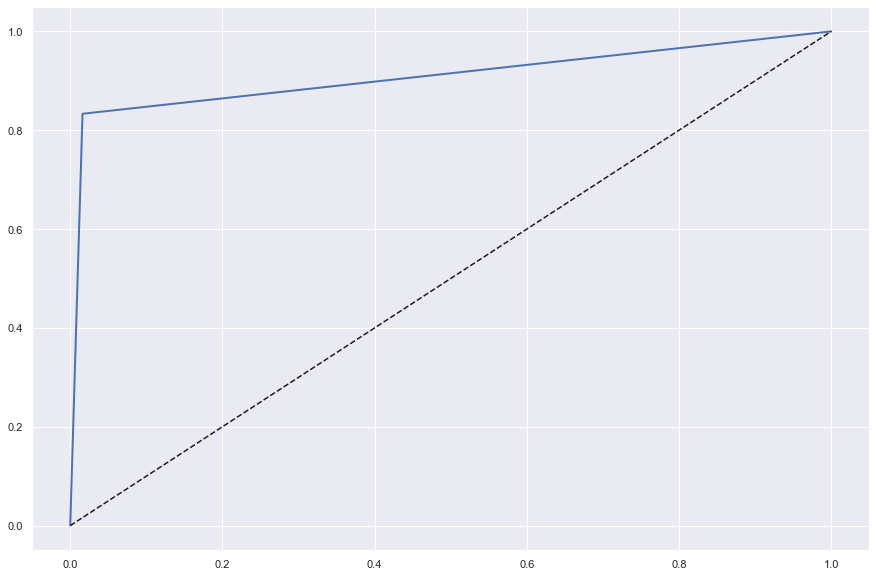

In [61]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_test, y_important_pred)
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    [...]
plot_roc_curve(fpr,tpr)
plt.show()

In [ ]:
def